# Using the Sup3rCC Data

This notebook has examples of how to access and use the Sup3rCC data. Note that you don't need a full sup3r software installation to run this notebook. Just a simple [rex](https://github.com/NREL/rex) environment with matplotlib will do it. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from rex import MultiFileResourceX, ResourceX

## Importing the Data

Here we load data from the 2015 and the 2050 files. Note that:

1. The 2015 year does not represent the actual historical weather in 2015, just the historical climate in 2015
2. Comparing single years is inprecise because normal variability in the climate can skew the results, we use single years here just for illustrative purposes
3. The access patterns are different if you're on Eagle (the NREL supercomputer) versus if you're accessing via a remote machine. In the latter case, you'll need to use HSDS. See the instructions [here](https://nrel.github.io/rex/misc/examples.hsds.html) for more details on how to set that up. The code below assumes you'll use an NREL API key, but if you want to setup a local HSDS server you'll have to modify `hsds_kwargs` accordingly.

In [2]:
option = 'eagle'

if option == 'eagle':
    # Use this code block if you want to access Sup3rCC data on Eagle
    data_dir = '/datasets/sup3rcc/conus_mriesm20_ssp585_r1i1p1f1/'
    fn_2015 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_*_2015.h5'
    fn_2050 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_*_2050.h5'
    handler_2015 = MultiFileResourceX(os.path.join(data_dir, fn_2015))
    handler_2050 = MultiFileResourceX(os.path.join(data_dir, fn_2050))
    
elif option == 'hsds':
    # Use this code block if you want to access Sup3rCC data remotely via HSDS
    data_dir = '/nrel/sup3rcc/'
    fn_2015 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_2015.h5'
    fn_2050 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_2050.h5'
    hsds_kwargs = {'endpoint': 'https://developer.nrel.gov/api/hsds', 
                   'api_key': '{PUT_YOUR_API_KEY_HERE}'}
    handler_2015 = ResourceX(os.path.join(data_dir, fn_2015), hsds=True, hsds_kwargs=hsds_kwargs)
    handler_2050 = ResourceX(os.path.join(data_dir, fn_2050), hsds=True, hsds_kwargs=hsds_kwargs)

else:
    raise NotImplementedError

In [5]:
dir(h5pyd)

['AttributeManager',
 'Config',
 'Dataset',
 'Datatype',
 'Empty',
 'ExternalLink',
 'File',
 'Folder',
 'Group',
 'HardLink',
 'Reference',
 'RegionReference',
 'SoftLink',
 'Table',
 'UserDefinedLink',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_hl',
 'absolute_import',
 'check_dtype',
 'check_enum_dtype',
 'check_opaque_dtype',
 'check_ref_dtype',
 'check_string_dtype',
 'check_vlen_dtype',
 'config',
 'enable_ipython_completer',
 'enum_dtype',
 'getServerInfo',
 'h5ds',
 'is_hdf5',
 'special_dtype',
 'string_dtype',
 'version',
 'vlen_dtype']

In [6]:
# coordinate for NREL campus
coord = (39.741, -105.171)

dsets = handler_2015.dsets
gid = handler_2015.lat_lon_gid(coord)
meta = handler_2015.meta
ti_2015 = handler_2015.time_index
data_2015 = pd.DataFrame({'ghi': handler_2015['ghi', :, gid],
                          'ws': handler_2015['windspeed_100m', :, gid],
                          'temp': handler_2015['temperature_2m', :, gid]},
                         index=ti_2015)

ti_2050 = handler_2050.time_index
data_2050 = pd.DataFrame({'ghi': handler_2050['ghi', :, gid],
                          'ws': handler_2050['windspeed_100m', :, gid],
                          'temp': handler_2050['temperature_2m', :, gid]},
                         index=ti_2050)

display(dsets)
display(meta.loc[gid])

['dhi',
 'dni',
 'ghi',
 'meta',
 'pressure_0m',
 'relativehumidity_2m',
 'temperature_2m',
 'time_index',
 'winddirection_100m',
 'winddirection_10m',
 'winddirection_200m',
 'windspeed_100m',
 'windspeed_10m',
 'windspeed_200m']

latitude         39.723133
longitude      -105.165001
timezone              -7.0
elevation             1876
country      United States
state             Colorado
county           Jefferson
offshore                 0
eez                      1
Name: 389950, dtype: object

## Comparing Differences in Temperature

Here, we can see that 2050 has an increase in average dry bulb temperature versus 2015, as well as more extreme hot and cold events.

,ghi,ws,temp
count,8760.000000,8760.000000,8760.000000
mean,210.618836,3.399327,8.489873
std,285.814293,2.126502,10.291715
min,0.000000,0.020000,-18.629999
25%,0.000000,1.880000,0.257500
50%,0.000000,2.980000,7.570000
75%,408.000000,4.420000,16.540001
max,1028.000000,16.670000,35.090000


,ghi,ws,temp
count,8760.000000,8760.000000,8760.000000
mean,220.782763,3.585060,9.843171
std,294.042404,2.375402,12.052267
min,0.000000,0.030000,-25.000000
25%,0.000000,1.880000,0.420000
50%,0.000000,3.040000,9.080000
75%,437.250000,4.710000,19.352500
max,1033.000000,16.180000,39.759998


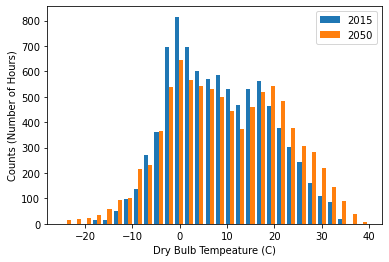

In [7]:
display(data_2015.describe())
display(data_2050.describe())

plt.hist([data_2015['temp'].values, data_2050['temp'].values], bins=30);
plt.xlabel('Dry Bulb Tempeature (C)')
plt.ylabel('Counts (Number of Hours)')
plt.legend(['2015', '2050'])

# Wind and Solar Resource

You can use joint probability distributions to visualize the distribution of syncronous wind and solar resources. In practice, you would want to use a tool like the System Advisor Model (SAM) or the Renewable Energy Potential Model (reV) to convert these meteorological variables into potential power generation.

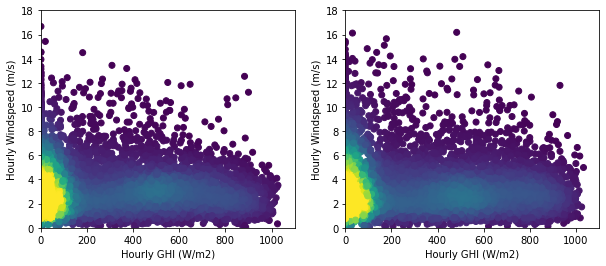

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def get_density(x, y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / (z.max() - z.min())
    return z

c1 = get_density(data_2015['ghi'], data_2015['ws'])
c2 = get_density(data_2050['ghi'], data_2050['ws'])

ax[0].scatter(data_2015['ghi'], data_2015['ws'], c=c1, vmin=0, vmax=0.5)
ax[1].scatter(data_2050['ghi'], data_2050['ws'], c=c2, vmin=0, vmax=0.5)

for subax in ax:
    subax.set_xlim(0, 1100)
    subax.set_ylim(0, 18)
    subax.set_xlabel('Hourly GHI (W/m2)')
    subax.set_ylabel('Hourly Windspeed (m/s)')

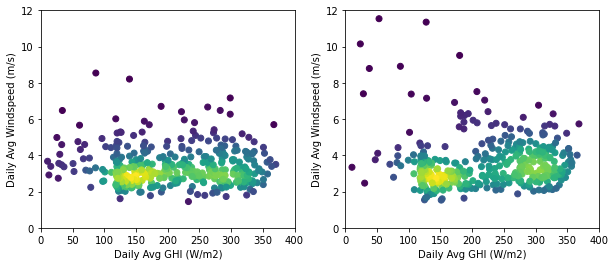

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def get_daily_means(arr):
    arr = np.roll(arr, -7)
    day_slices = [slice(i, i+24) for i in range(0, 8760, 24)]
    arr = [arr[islice].mean() for islice in day_slices]
    return np.array(arr)

ghi_2015 = get_daily_means(data_2015['ghi'])
ghi_2050 = get_daily_means(data_2050['ghi'])
ws_2015 = get_daily_means(data_2015['ws'])
ws_2050 = get_daily_means(data_2050['ws'])

c1 = get_density(ghi_2015, ws_2015)
c2 = get_density(ghi_2050, ws_2050)

ax[0].scatter(ghi_2015, ws_2015, c=c1, vmin=0, vmax=1)
ax[1].scatter(ghi_2050, ws_2050, c=c2, vmin=0, vmax=1)

for subax in ax:
    subax.set_xlim(0, 400)
    subax.set_ylim(0, 12)
    subax.set_xlabel('Daily Avg GHI (W/m2)')
    subax.set_ylabel('Daily Avg Windspeed (m/s)')